Mount google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import the data.

In [2]:
import pandas as pd

data_path = '/content/drive/MyDrive/ColabNotebooks/ITP359/Project/Submission/Data.csv'
btc_data = pd.read_csv(data_path)

print(btc_data.head())

         Date      Price       Open       High       Low     Vol. Change %
0  12/11/2024  101,051.3   96,603.2  101,073.9  95,689.5  247.57K    4.61%
1  12/10/2024   96,600.3   97,311.5   98,237.8  94,304.5  271.45K   -0.78%
2  12/09/2024   97,359.4  101,129.7  101,198.6  94,395.8  321.01K   -3.72%
3  12/08/2024  101,115.8   99,837.0  101,339.9  98,713.9  128.93K    1.28%
4  12/07/2024   99,837.0   99,757.2  100,441.8  98,969.0  118.44K    0.08%


3. Keep only the daily high prices.

In [4]:
btc_high_data = btc_data[['Date', 'High']]

print(btc_high_data.head())

         Date       High
0  12/11/2024  101,073.9
1  12/10/2024   98,237.8
2  12/09/2024  101,198.6
3  12/08/2024  101,339.9
4  12/07/2024  100,441.8


4. Split the data into train and test. Train should be for the years before 2024. Test should be 2024 onward.


In [5]:
#change to datetime
btc_high_data['Date'] = pd.to_datetime(btc_high_data['Date'])

#clear format and change to float
btc_high_data['High'] = btc_high_data['High'].replace(',', '', regex=True).astype(float)

train_data = btc_high_data[btc_high_data['Date'] < pd.Timestamp(year=2024, month=1, day=1)]
test_data = btc_high_data[btc_high_data['Date'] >= pd.Timestamp(year=2024, month=1, day=1)]

print("Train Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())

Train Data:
          Date     High
346 2023-12-31  42878.8
347 2023-12-30  42592.2
348 2023-12-29  43108.0
349 2023-12-28  43782.6
350 2023-12-27  43676.7

Test Data:
        Date      High
0 2024-12-11  101073.9
1 2024-12-10   98237.8
2 2024-12-09  101198.6
3 2024-12-08  101339.9
4 2024-12-07  100441.8


<ipython-input-5-abd024d25cee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_high_data['Date'] = pd.to_datetime(btc_high_data['Date'])
<ipython-input-5-abd024d25cee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_high_data['High'] = btc_high_data['High'].replace(',', '', regex=True).astype(float)


5. Visualize the time series.


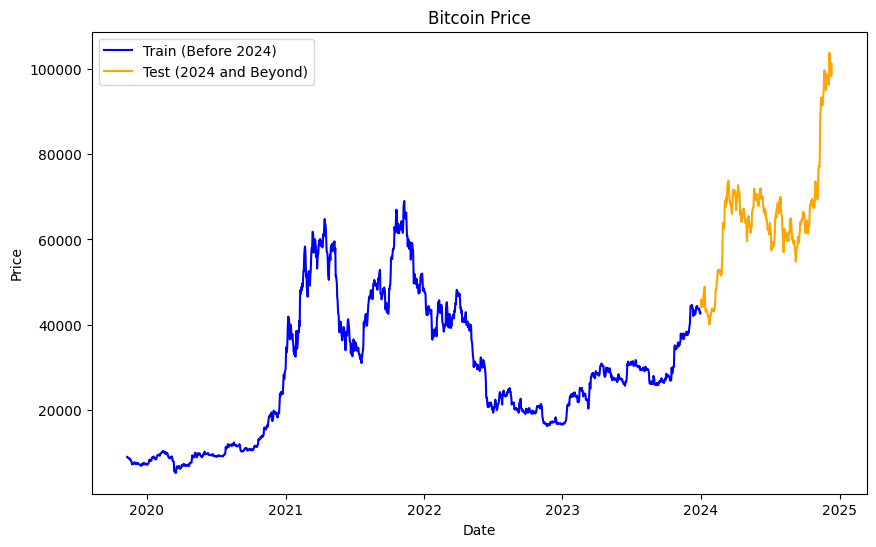

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train_data['Date'], train_data['High'], label='Train (Before 2024)', color='blue')
ax.plot(test_data['Date'], test_data['High'], label='Test (2024 and Beyond)', color='orange')

ax.set_title('Bitcoin Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

ax.legend()

plt.show()

6. Scale the data


In [82]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

#only need High
btc_high_data_High = train_data['High'].values.reshape(-1, 1)
print(btc_high_data_High[:5])
train_data_temp = train_data
train_data_temp['High'] = scaler.fit_transform(btc_high_data_High)

btc_high_data_High_test = test_data['High'].values.reshape(-1, 1)
print(btc_high_data_High_test[:5])
test_data_temp = test_data
test_data_temp['High'] = scaler.fit_transform(btc_high_data_High_test)

[[0.58957456]
 [0.58506978]
 [0.59317713]
 [0.60378049]
 [0.60211596]]
[[0.95837791]
 [0.91375708]
 [0.96033984]
 [0.96256293]
 [0.94843298]]


<ipython-input-82-1da058ce897d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_temp['High'] = scaler.fit_transform(btc_high_data_High)
<ipython-input-82-1da058ce897d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_temp['High'] = scaler.fit_transform(btc_high_data_High_test)


7. Make sequences that will be used to predict the next day’s price. E.g. last 30 days to predict the price for the 31st day.

In [83]:
def create_sequences(data, n_sequence):
    X, y = [], []
    for i in range(len(data) - n_sequence):
        X.append(data[i:(i + n_sequence)])
        y.append(data[i + n_sequence])
    return np.array(X), np.array(y)

n_sequence = 30

sequence_data = train_data_temp['High'].values
X, y = create_sequences(sequence_data,n_sequence)

sequence_data_test = test_data_temp['High'].values
X_test, y_test = create_sequences(sequence_data_test,n_sequence)

# X shape and y shaepe
print("X shape:", X.shape)
print("y shape:", y.shape)

#Check first 5
print("X:\n", X[:1])
print("y:\n", y[:1])

X shape: (1483, 30)
y shape: (1483,)
X:
 [[0.58957456 0.58506978 0.59317713 0.60378049 0.60211596 0.60083023
  0.60393925 0.60618692 0.60711271 0.61339991 0.6109982  0.6115782
  0.59891892 0.58720429 0.58225626 0.58661172 0.59274803 0.59765204
  0.59804185 0.57687598 0.60415301 0.60791119 0.61287493 0.61816247
  0.6079269  0.61165679 0.6138636  0.58196076 0.54713752 0.53919206]]
y:
 [0.52783423]


8. Build an RNN neural network.

In [84]:
from keras.models import Sequential
from keras.layers import Dense

input_shape = X.shape[1]

# construct model
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # only 1 for output for the value
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9. Compile and train it.


In [85]:
model.compile(optimizer='adam', loss='mse')

model.summary()

model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0672 - val_loss: 5.6535e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 1.5590e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 1.5468e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7366e-04 - val_loss: 1.2747e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 9.2848e-05
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0752e-04 - val_loss: 4.3257e-05
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5206e-04 - val_loss: 9.7015e-05
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7962e-04 - val_loss: 5.3720e-05
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1616e-04 - val_loss: 4.7295e-05
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1538e-04 - val_loss: 4.6526e-05
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0857e-04 - val_loss: 4.3136e-05
E

10. Predict the prices for the test data.


In [86]:
predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)

print(predictions[:10])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.7911652 ]
 [0.76599735]
 [0.6893205 ]
 [0.60829633]
 [0.57115227]
 [0.55374485]
 [0.54854923]
 [0.48581013]
 [0.4587521 ]
 [0.4442482 ]]


11. Visualize the actual and predicted prices.


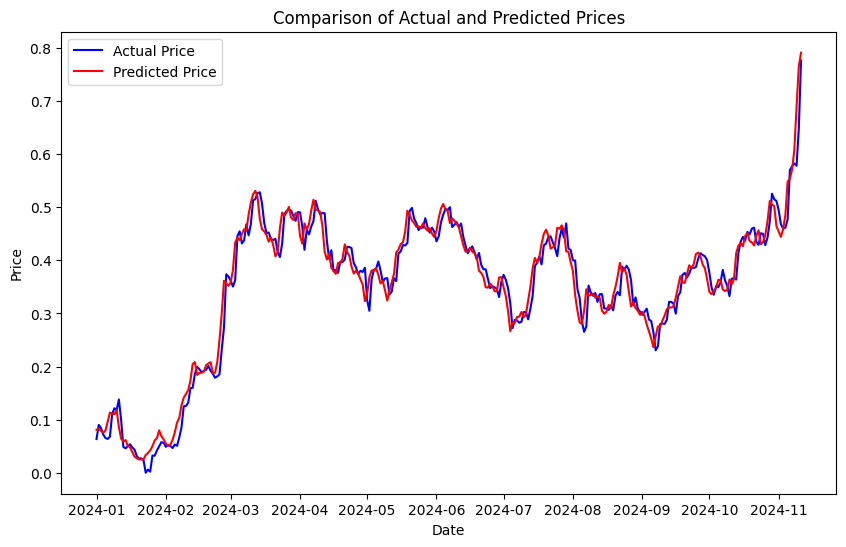

In [91]:
#drop first 30 days for prediction
date_range = test_data['Date'][30:].reset_index(drop=True)
actual_prices = test_data['High'][30:].reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(date_range, actual_prices, label='Actual Price', color='blue')
plt.plot(date_range, predictions, label='Predicted Price', color='red')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()